# Final project: Quantifying errors in IonQ native gates and composite pulses

Nicholas Yama and I-Tung Chen

### References

[1] https://docs.microsoft.com/en-us/azure/quantum/provider-ionq

[2] A Grand Unification of Quantum Algorithms (https://arxiv.org/abs/2105.02859) 


## Introduction

The IonQ trapped-ion quantum computer is among the few noisy intermediate-scale quantum (NISQ) computers available via cloud services to the general public.
The ability to test algorithms on NISQ devices is an important tool for the advancement of quantum information science.
Beyond the target application space, there is also much opportunity for the study of inherent noise of NISQ devices which serves as a basic plaform for the development of algorithmic-level approaches towards improving the robustness of quantum information devices overall.
Our goal with this project will be to probe the noise of the IonQ QPU native gates directly and then implement techniques to compensate for the errors that arise.
To do this we first perform a series of experiments similar to the randomized benchmarking done in a previous homework for this course.
After quantifying the types of errors observed we then seek to implement the BB1 protocol (also from a previous homework) and compare the effectiveness of this approach for different parameters such as the angle of rotation.



## Quantification of error on the native gates

The IonQ system is equipped with two user-accessible native gates for single-qubit operations: the GPi and GPi2 gates.
Both of these gates are physically implemented as $\pi$ and $\pi/2$ Rabi oscillations of individual qubits within the system.
As such, these gates are prone to errors which arise from both amplitude and pulse length errors which result in over-/under-rotations of the qubit on the Bloch sphere.
There is also the potential for phase errors but these are implemented internal to the control system and thus are expected to have a higher degree of fidelity than the physically implemented pulse-type errors.
Our goal for this section is to probe both the pulse and phase errors.

A general rotation by angle $\theta$ around axis given by $\hat n$ is given by the matrix exponential

\begin{equation}
    R_{\hat n} (\theta) = \exp\Bigg( - \frac{i\theta \hat n \cdot \mathbf{\sigma} }{2} \Bigg)
\end{equation}

which can also be expressed in the form

\begin{equation}
    R_{\hat n} (\theta) = \cos\frac{\theta}{2} I - i \sin\frac{\theta}{2} (n_x X + n_y Y + n_z Z).
\end{equation}

Restricting ourselves to rotations about axes in the $xy$-plane given by azimuthal angle $\varphi$ then we can write the matrix form

\begin{equation}
    R_{\varphi} (\theta) = 
    \begin{bmatrix}
        \cos\frac{\theta}{2} & -i e^{-i\varphi} \sin\frac{\theta}{2} \\
        -i e^{i\varphi} \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{bmatrix}.
\end{equation}

From here we are able to explicitly relate the single-qubit native gates of the IonQ system to rotations on the Bloch sphere.

The GPi gate is given by the matrix

\begin{equation}
    GPI(\phi) = 
    \begin{bmatrix}
        0 & e^{-i\phi} \\ e^{i\phi} & 0
    \end{bmatrix}
\end{equation}

As the documentation (and name) suggests, the GPi gate implements a $\pi$ rotation of the qubit about an arbitrary azimuthal axis.
One observes that the rotation axis is indeed given by the azimuthal angle $\phi$ but we do not include the effect of an overal global phase of $-i$ which would directly equate it to the $R_\phi(\pi)$ gate.
Thus we make the equivalence

\begin{equation}
    GPI(\phi) = i R_\phi(\pi),
\end{equation}

which establishes the first single-qubit native gate as a rotation.

Similarly the GPi2 gate

\begin{equation}
    GPI_2(\phi) = \frac{1}{\sqrt{2}}
    \begin{bmatrix}
        1 & -ie^{-i\phi} \\ -ie^{i\phi} & 1
    \end{bmatrix} 
\end{equation}

is straightforwardly seen to be a $\pi/2$ rotation about the axis $\phi$.
We can similarly establish

\begin{equation}
    GPI_2(\phi) = R_\phi(\pi/2).
\end{equation}

With this in mind we first move to quantify the error rates of the native gates directly.
According to [1], single-qubit gates on the IonQ system have a fidelity of 99.35% (SPAM corrected), whilst the SPAM errors themselves correspond to a fidelity of 99.3-99.8%.
Thus, we should be able to observe errors reasonably at a few thousand shots, and we can increase the error signal by increasing the number of gate operations performed.
Since the phase error (associated with the argument $\phi$) is expected to be small, if we were to run the same experiments with varied axes of rotation, this would allow for us to probe the systematic errors directly which should alleviate some of the noise from SPAM errors.

The plan is to run circuits with varying numbers of GPi and GPi2 gates (separately) and with different numbers of shots and at different angles and run tomography on them to determine potential systematic pulse-type errors.
One key point is that these errors will differ in amplitude depending on things such as the time since the last calibration sequence.
Thus, it is important to keep track of when the circuits were run on the machine.


## A directly implementable composite pulse: BB1$_\pi$

A pulse sequence that we can directly implement and easily check is the BB1$_\pi$ pulse sequence given by

\begin{equation}
    BB1_{\theta = \pi} = R_\phi(\pi) R_{3\phi} (2\pi) R_{\phi} (\pi) R_x (\theta = \pi)
\end{equation}

where $\cos\phi = - \theta / 4 \pi$, which is a composite pulse sequence that implements an arbitrary $R_x(\theta)$ with sixth-order supression of pulse-length errors.
In the specific case of $\theta=\pi$ we can implement all of these gates directly using the native gates and so this is a good opportunity to verify the usefulness of composite pulses --- this is essentially what we did in the previous homework.

First we can import the necessary modules:

In [2]:
from qiskit_ionq import IonQProvider, GPIGate, GPI2Gate
from qiskit.providers.jobstatus import JobStatus


import numpy as np
import matplotlib.pyplot as plt

In [3]:
provider = IonQProvider('p0SJZ9pWbx1Y2gw0BjJilGYXPBNCjAjy')

from qiskit.providers.aer import QasmSimulator
qasm_backend = QasmSimulator()

sim_backend_qis = provider.get_backend('ionq_simulator', gateset='qis')
sim_backend_nat = provider.get_backend('ionq_simulator', gateset='native')

qpu_backend_qis = provider.get_backend('ionq_qpu', gateset='qis')
qpu_backend_nat = provider.get_backend('ionq_qpu', gateset='native')

In [4]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector
from qiskit.quantum_info import Statevector, DensityMatrix, state_fidelity

Let us first consider an implementation using an ideal machine via the QASM simultator and simulating the error directly.

Suppose we have a pulse-length error that takes $R_x(\theta) \to R_x(\theta(1+\epsilon))$.
As a result the $R_x(\pi)$ will over rotate an arbitrary input; some amount of the resulting output will thus measure as 0 rather than 1 as expected:

In [12]:
# Define the angles
theta = np.pi
phi = np.arccos(- theta / (4 * np.pi))

# Define the error
epsilon = 0.1
ttheta = np.pi * (1 + epsilon)

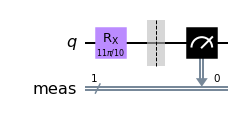

In [13]:
circ_rx = QuantumCircuit(1)

# Using a circuit with a pulse-length error
circ_rx.rx(theta=ttheta, qubit=0)

circ_rx.measure_all()

circ_rx.draw('mpl')

Now running the job on the QASM simulator backend we see that there is some number of measurements of 0, despite the desired implementation being a $\pi$ pulse.

In [14]:
job = qasm_backend.run(circ_rx, shots=1000000) 

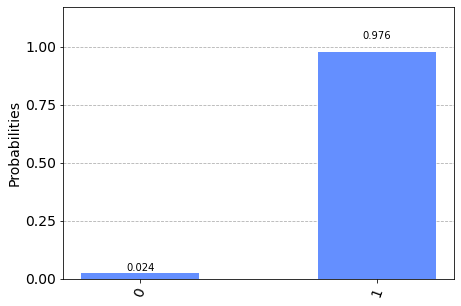

In [15]:
plot_histogram(job.result().get_counts())

Compare this to the BB1$_\pi$ implementation:

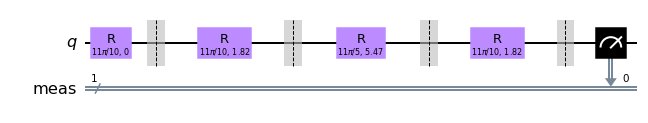

In [16]:
circ_BB1 = QuantumCircuit(1)

# Note that the error occurs in all parts of the pulse
circ_BB1.r(theta=ttheta, phi=0, qubit=0)
circ_BB1.barrier()
circ_BB1.r(theta=np.pi * (1 + epsilon), phi=phi, qubit=0)
circ_BB1.barrier()
circ_BB1.r(theta=2*np.pi * (1 + epsilon), phi=3 * phi, qubit=0)
circ_BB1.barrier()
circ_BB1.r(theta=np.pi * (1 + epsilon), phi=phi, qubit=0)
circ_BB1.measure_all()

circ_BB1.draw('mpl')

Running the job for the BB1 pulse sequence, we see that the errors are significantly surpressed (note that we are running 1 million shots!):

In [35]:
job = qasm_backend.run(circ_BB1, shots=1000000) 

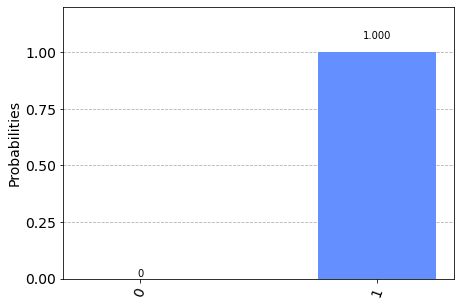

In [36]:
plot_histogram(job.result().get_counts())

### Implementation with native gates on the IonQ system

We can directly implement this sequence using the native gates.

First the $R_x(\pi)$ control experiment which is directly implemented by a GPi pulse:

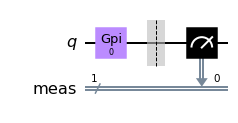

In [46]:
circ_rx = QuantumCircuit(1)

# Implement the Rx(pi) via a single GPI with argument phi = 0
circ_rx.append(GPIGate(0),[0]) 
circ_rx.measure_all()

circ_rx.draw('mpl')

The BB1 pulse sequence can similarly be implemented using GPi pulses and choosing the argument $\phi$ correctly:

In [17]:
# Define the angles
theta = np.pi
phi = np.arccos(- theta / (4 * np.pi))

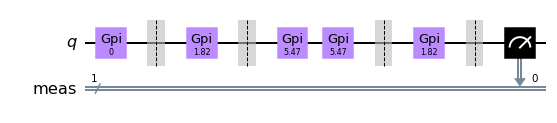

In [18]:
circ_BB1 = QuantumCircuit(1)

circ_BB1.append(GPIGate(0),[0]) 
circ_BB1.barrier()
circ_BB1.append(GPIGate(phi),[0]) 
circ_BB1.barrier()

# The 2*pi pulse around 3*phi is implemented via two GPi Gates
circ_BB1.append(GPIGate(3 * phi),[0]) 
circ_BB1.append(GPIGate(3 * phi),[0]) 
circ_BB1.barrier()
circ_BB1.append(GPIGate(phi),[0]) 


circ_BB1.measure_all()

circ_BB1.draw('mpl')

Let us run the jobs on the IonQ simulator backend using the native gateset:

In [52]:
job1 = sim_backend_nat.run(circ_rx, shots=100000)
job2 = sim_backend_nat.run(circ_BB1, shots=100000)

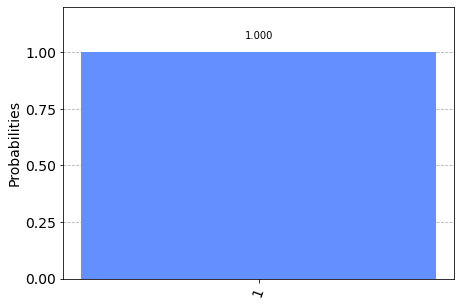

In [53]:
# Direct Rx
plot_histogram(job1.result().get_counts())

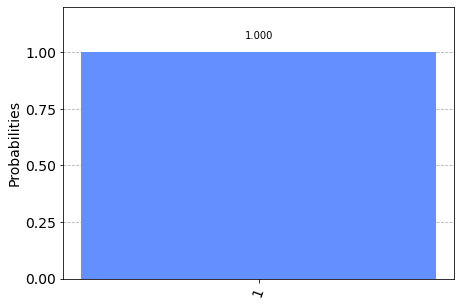

In [54]:
# BB1 implementation
plot_histogram(job2.result().get_counts())

Seemingly, the simulator does not seem to include the noise one would expect.
We are not sure if this is because the simulator assumes better results than expected or if there is some other resason that leads to this.

For now we attempt to run the same experiments on the QPU (with less shots): 

In [69]:
job1 = qpu_backend_nat.run(circ_rx, shots=10000)
job2 = qpu_backend_nat.run(circ_BB1, shots=10000)

In [70]:
print('job1 (R_x) ID:', job1.job_id())
print('job2 (BB1) ID:', job2.job_id())

job1 (R_x) ID: a3593da7-057e-4608-82ad-9500fcad4d47
job2 (BB1) ID: 31135be4-2f7c-4c52-ad28-81f2c256001e


I keep the job IDs here for future reference:

    job1 (R_x) ID: a3593da7-057e-4608-82ad-9500fcad4d47
    job2 (BB1) ID: 31135be4-2f7c-4c52-ad28-81f2c256001e
    
As a note for comparison, this job was submitted sometime around 1 am on Monday, 06 June 2022.
It is possible that the results will change depending on when the job was submitted since calibrations may be done on the system at different times.
    
Since it might take some time we will retrieve the jobs directly and check their status with the below code:

In [4]:
job1 = qpu_backend_nat.retrieve_job('a3593da7-057e-4608-82ad-9500fcad4d47')
job2 = qpu_backend_nat.retrieve_job('31135be4-2f7c-4c52-ad28-81f2c256001e')

print('RX ; ID:','a3593da7-057e-4608-82ad-9500fcad4d47', 'is done?',job1.done())
print('BB1; ID:','31135be4-2f7c-4c52-ad28-81f2c256001e', 'is done?',job2.done())

RX ; ID: a3593da7-057e-4608-82ad-9500fcad4d47 is done? True
BB1; ID: 31135be4-2f7c-4c52-ad28-81f2c256001e is done? True


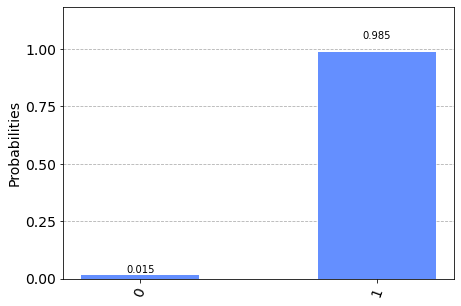

In [5]:
# Direct Rx
plot_histogram(job1.result().get_counts())

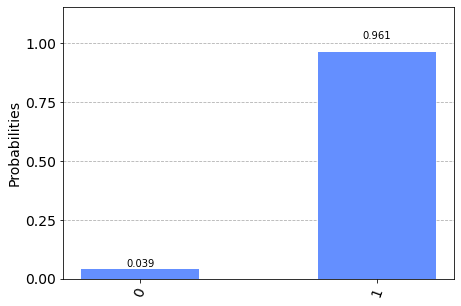

In [6]:
# BB1 implementation
plot_histogram(job2.result().get_counts())

Unfortunately, it seems as though the performance of the BB1 circuit is at best comparable to the direct implementation, if not slightly worse.
This is perhaps not too surprising since the BB1 sequence is intended to correct for only the specific type of errors corresponding to _consistent_ pulse-length errors.
If the errors here are a result of SPAM-type noise or other stochastic sources, then it is likely that these sources of noise are masking any corrections to small pulse length errors that BB1 achieves.
Recall that even large errors of about 10% over-rotation in the QASM simulations produced noise to a similar degree (by measure of spurious 0 counts).
It would be expected that the IonQ system has pulse-length errors that are at least smaller than this error rate, so the noise signal is expected to be quite small.


Very simple heuristic way to check the error is to just consider the effect of SPAM errors and gate fidelity directly.
We know from [1] that the average single-qubit gate fidelity is expected to be about 99.3% whereas the SPAM has fidelity of about 99.3-99.8%.
Taking the average SPAM error as 99.5% then we can roughly estimate the fidelity of the circuits as a product $F \approx F_{SPAM} \cdot (F_{GATE})^N$ where $N$ is the number of gates used.
From here we can estimate the $R_x$ circuit to have fidelity $F_{R_x} \approx 0.995 \cdot 0.993 \approx 98.8%$ which is not too far off from the measured "fidelity" of the operation if one measures this as the probability that the desired outcome occurs (i.e. measuring a 1).
Similarly, we have $N = 5$ for the BB1 circuit giving an estimated fidelity of $F_{BB1} \approx 96.0%$ which is also quite close to the measured probabilities.
This seems to indicate that the increased error rate is likely a result of the lower fidelity of the gates which limits the overal performance directly.
Unfortunately this means that the increased number of gates used in the BB1 circuit is expected to increase error rate in most cases; this is especially true if the error is stochastic versus the systematic error targeted by BB1.


We are able to have some confidence in this result as the observed signal to noise ratio (SNR, here defined as 1/P(0)) ranges from about 33-66.
Given that the number of shots (1e4) should result in an SNR of $\sqrt{1e4}=100$, we expect the results to **not** be limited by shot noise, but instead other sources such as the decreased gate fidelity as discussed previously.

## General BB1

The goal of this section is to implement a general BB1 protocol using the IonQ system.

A challenge that we are forced deal with, however, is that we are not able to do general $R_x(\theta)$ rotations directly in the IonQ native gate set.
Instead we will have to determine a means of implementing such rotations using the native gate set.
This is goal of the following subsection.

### Arbitrary rotations with the native gates

One challenge that we have to deal with is that the native gates cannot directly implement rotations of arbitrary polar angle (angle with respect to the zenith, or $z$, axis).
Physically this could reasonably be implemented in a similar manner to the GPi/GPi2 pulses where an arbitrary angle Rabi oscillation could be peformed, however there are probably good reasons that IonQ has chosen not to enable control pulses of this type.
As a result of this however (and due to the fact that the transpiler does not seem to be able to convert such rotations directly) we must determine a means of achieving these rotations ourselves.

It is relatively straightforward to perform arbitrary $R_x(\theta)$ rotations using the GPi and GPi2 pulses.
From the previous homework the following sequence can be show to implement such an arbitrary rotation:

1. Rotate about $y$ by $-\pi/2$ --- this puts $+x$ on the $+z$-axis
2. Perform the rotation about $z$ by $\theta$ --- this does the desired arbitrary rotation
3. Rotate about $y$ by $+\pi/2$ --- the $+x$-axis back along $+x$

Indeed, if we had access to direct $R_z(\theta)$ rotations --- which, for whatever reason, IonQ is not keen on providing us --- then we would be able to implement arbitrary rotations about any axis in the $xy$ plane.


Let us try it analytically:

In [1]:
import sympy as sp

First we just make the required $R_y(\theta)$ and $R_z(\theta)$ gates:

In [2]:
theta = sp.symbols('theta')

In [4]:
Ry = sp.Matrix(
    [[sp.cos(theta/2), - sp.sin(theta/2)],
     [sp.sin(theta/2), sp.cos(theta/2) ]]
)
Ry

Matrix([
[cos(theta/2), -sin(theta/2)],
[sin(theta/2),  cos(theta/2)]])

In [5]:
Rz = sp.Matrix(
    [[sp.cos(theta/2) - sp.I * sp.sin(theta/2), 0],
     [0, sp.cos(theta/2) + sp.I * sp.sin(theta/2)]]
)
Rz

Matrix([
[-I*sin(theta/2) + cos(theta/2),                             0],
[                             0, I*sin(theta/2) + cos(theta/2)]])

We can define the $R_y$ rotations:

In [6]:
Ry_pi2 = Ry.subs(theta, sp.pi/2)
Ry_pi2

Matrix([
[sqrt(2)/2, -sqrt(2)/2],
[sqrt(2)/2,  sqrt(2)/2]])

The inverse is just the adjoint:

In [9]:
Ry_pi2.adjoint()

Matrix([
[ sqrt(2)/2, sqrt(2)/2],
[-sqrt(2)/2, sqrt(2)/2]])

Implementing the simple pulse sequence gives:

In [11]:
Rx =  Ry_pi2 * Rz * Ry_pi2.adjoint()
Rx

Matrix([
[   cos(theta/2), -I*sin(theta/2)],
[-I*sin(theta/2),    cos(theta/2)]])

Which is the correct form for $R_x$ which can be seen by comparing to $R_{\phi=0}(\theta)$ from above.

Thus we implement a general $R_x(\theta)$ rotation in the native gateset by the unitary

\begin{equation}
    R_x(\theta) = GPI_2(\phi=\pi/2) GZ(\theta) GPI_2^\dagger(\phi=\pi/2) = GPI_2(\phi=\pi/2) GZ(\theta) GPI_2(\phi=-\pi/2)
\end{equation}

Unfortunately, IonQ does not allow for direct usage of the $GZ(\theta) = R_z(\theta)$ gate in the circuit compilation and so we have to manually append the phase offset to all future gates, i.e.


\begin{equation}
    R_x(\theta) \equiv GPI_2(\phi=\pi/2 + \theta) GPI_2(\phi=-\pi/2).
\end{equation}

Note that this requires that **all** subsequent gates are phase shifted by $\theta$.

### Implementing general BB1$_\theta$

The BB1 sequence is thus implemented in the native gate set as

\begin{equation}
    BB1_{\theta = \pi} = \underbrace{GPI(\phi + \theta)}_{R_{\phi} (\pi)} \cdot
    \underbrace{GPI(3\phi + \theta)GPI(3\phi + \theta)}_{R_{3\phi} (2\pi)} \cdot
    \underbrace{GPI(\phi + \theta)}_{R_{\phi} (\pi)} \cdot
    \underbrace{GPI_2(\pi/2 + \theta) GPI_2(-\pi/2)}_{R_x(\theta)}.
\end{equation}

We write a function which allows us to generate circuits implementing this and the plain $R_x(\theta)$:

In [66]:
def get_BB1_circ(theta):
    
    # Calculate the rotation axis angle
    phi = np.arccos(- theta / (4 * np.pi))
    
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.append(GPI2Gate(-0.25),[0]) 
    circ.append(GPI2Gate(0.25 + theta),[0]) 
    
    circ.barrier()
    
    # R_{phi}(pi)
    circ.append(GPIGate(phi + theta),[0]) 
    
    circ.barrier()

    # R_{3phi}(2pi)
    circ.append(GPIGate(3 * phi + theta),[0]) 
    circ.append(GPIGate(3 * phi + theta),[0]) 
    
    circ.barrier()
    
    # R_{phi}(pi)
    circ.append(GPIGate(phi + theta),[0]) 

    # Measure the qubit
    circ.measure_all()

    circ.draw('mpl')
    
    return circ
    
def get_Rx_circ(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.append(GPI2Gate(-0.25),[0]) 
    circ.append(GPI2Gate(0.25 + theta),[0]) 
    
    # Measure the qubit
    circ.measure_all()

    circ.draw('mpl')
    
    return circ

#### IonQ Simulator

Let us first test attempt to replicate the curves using the QASM simulator:

In [67]:
thetas = np.linspace(-0.5, 0.5, 11)
thetas

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

Note that the angle inputs for the GPi/GPi2 gates are in fractions of $2\pi$.

In [68]:
bb1_circuits = []
rx_circuits = []

for theta in thetas:
    bb1_circuits.append(get_BB1_circ(theta))
    rx_circuits.append(get_Rx_circ(theta))

Run the circuits:

In [69]:
bb1_jobs = []
for circuit in bb1_circuits:
    bb1_jobs.append( sim_backend_nat.run(circuit, shots=1000000) )

In [70]:
rx_jobs = []
for circuit in rx_circuits:
    rx_jobs.append( sim_backend_nat.run(circuit, shots=1000000) )

Analyze the results:

In [8]:
def calc_p0(counts):
    
    try:
        counts['1']
    except:
        counts['1'] = 0
        
    try:
        counts['0']
    except:
        counts['0'] = 0
    
    total = counts['0'] + counts['1']
    return counts['0'] / total

In [72]:
bb1_p0s = []
for job in bb1_jobs:
    print(job.result().get_counts())
    
    bb1_p0s.append( calc_p0(job.result().get_counts()) )

{'1': 1000000}
{'0': 96123, '1': 903877}
{'0': 345415, '1': 654585}
{'0': 653992, '1': 346008}
{'0': 904531, '1': 95469}
{'0': 1000000}
{'0': 904181, '1': 95819}
{'0': 654259, '1': 345741}
{'0': 345968, '1': 654032}
{'0': 95333, '1': 904667}
{'1': 1000000}


In [73]:
rx_p0s = []
for job in rx_jobs:
    print(job.result().get_counts())
    rx_p0s.append( calc_p0(job.result().get_counts()) )

{'1': 1000000}
{'0': 95475, '1': 904525}
{'0': 345788, '1': 654212}
{'0': 653738, '1': 346262}
{'0': 904756, '1': 95244}
{'0': 1000000}
{'0': 903785, '1': 96215}
{'0': 653560, '1': 346440}
{'0': 345869, '1': 654131}
{'0': 95058, '1': 904942}
{'1': 1000000}


We can easily see that the general BB1 protocol implements the desired rotation for arbitrary $\theta$.
This is made clear by comparing the count rates to form the curve:

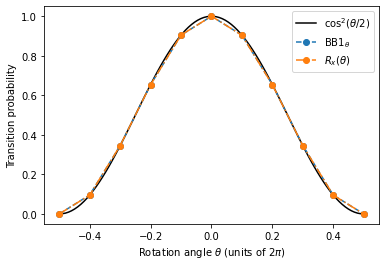

In [74]:
theta = np.linspace(-0.5, 0.5, 100)
theory = np.cos(np.pi * theta) ** 2 
plt.plot(theta, theory, 'k', label=r'$\cos^2(\theta/2)$')

plt.plot(thetas, bb1_p0s, 'o--', label=r'BB1$_\theta$')
plt.plot(thetas, rx_p0s, 'o-.', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (units of $2\pi$)')

plt.legend()

plt.show()

In the above plot, the black curve is the theoretical curve given for the rotation.
Both the BB1 and $R_x$ samples overlap to a great extent.
This shows that the BB1 protocol implements the rotation as desired for arbitrary angles (in the case where the noise was determined by the simulation backend).

An interesting point to note here is that the effect of pulse length errors does not show up in the same way within the IonQ system for general rotations.
The reason for this is that the pulse lengths are tied explicitly to the GPi and GPi2 gates themselves and our general rotation is accomplished using a virtual rotation accomplished by modulating the phases of the individual gates.
If there were to be overshooting errors these would be embedded within the GPi and GPi2 gates directly such that they implement slight over-/under-rotations.
Our general $R_x(\theta)$ sequence thus does not obtain simple over-/under-shooting errors, but will instead generally have slight phase errors due to the GPi2 pulses not taking the $x$-axis to the zenith (i.e. the rotations are performed around axes slightly off from $+x$).

Thus, the overshooting errors do not affect general rotations in the same way that they do for the "discrete" rotations embedded within the gate set.
Perhaps unsurprisingly, implenting the BB1 protocol is perhaps best done closest to the machine level, such that the GPi and GPi2 gates directly implement it instead of the general Rabi oscillation pulses it is expected to currently use.

## BB1 in the quantum signal processing context

Although BB1 may not serve as a means of counteracting error in the currently available NISQ systems, there is potential for BB1 to have significance in other aspects, such as modifying the parameter sensitivity as discussed in [2] and by Prof. Chuang in the lecture.
Such modification of the transition probability bears some significance to generalizations of quantum algorithms.


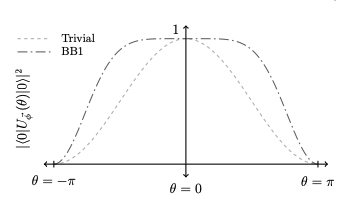

A perhaps confusing point about this figure is that it appears to show that BB1 has different behavior as $\theta$ is varied in comparison to a general rotation.
We know this is not true given our above implementation in the IonQ simulator (both the BB1 and $R_x$ curves have identical shape).
Retrospectively, this is the expected behavior --- if the BB1 curve did not match the $R_x$ curve directly then it would not be useful as a general rotation composite pulse!
In other words, the modified curve above does not show BB1 in the same context that we have been considering it up to this point.
We can understand how this curve is formed from a quantum signal processing (QSP) context.

Following the discussion in [2], the BB1 sequence (and indeed general QSP sequences) can be represented as a sequence of operations:

\begin{equation}
    U = e^{i\phi_0 Z} \prod_{k=1}^{d} W(a) e^{i \phi_k Z},
\end{equation}

i.e. a series of interleaved $R_z$ rotations by a vector of angles $\phi$ and a single operator $W(a)$.
To not stray too far from what has already been discussed, we note that the rotation operator $W(a)$ is can be taken to be an $x$-rotation operator by angle $\theta = -2\cos^{-1}a$.
In otherwords we can let $W(a) = R_x(-2\cos^{-1}a)$ --- since we want to parameterize in terms of $\theta$ anyway it is fine to ignore the $a$ variable for this work.

As given by [2], the set of phases $\phi = (\pi/2, -\eta, 2\eta, 0, -2\eta, \eta)$ with $\eta = \cos^{-1}(-1/4) / 2$ gives the BB1 sequence.
This is different from the above BB1 consider in the previous parts.
We do not fully understand the distinction between these two sequences.

Let us attempt to implement the sequence using the simulators first:

### QASM simulation

An important note: the QSP description uses a series of $Z$ operator exponentials.
This corresponds to a $Z$ rotation, however the precise angle of the rotation is not $\phi$ but actually $-2\phi$ due to the definition of the rotation operators. This change is important in following code.

In [108]:
def qsp_bb1(theta):
    
    circ = QuantumCircuit(1)
    
    eta = np.arccos(-1/4) / 2
    phi = [np.pi/2, -eta, 2*eta, 0, -2*eta, eta]

    # 5
    circ.rz(phi=-2*phi[5], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 4
    circ.rz(phi=-2*phi[4], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 3
    circ.rz(phi=-2*phi[3], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 2
    circ.rz(phi=-2*phi[2], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 1
    circ.rz(phi=-2*phi[1], qubit=0)
    circ.rx(theta=theta, qubit=0)
    circ.barrier()
    
    # 0
    circ.rz(phi=-2*phi[0], qubit=0)
    
    circ.measure_all()

    return circ

def Rx_circ(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.rx(theta, qubit=0)
    
    # Measure the qubit
    circ.measure_all()
    
    return circ

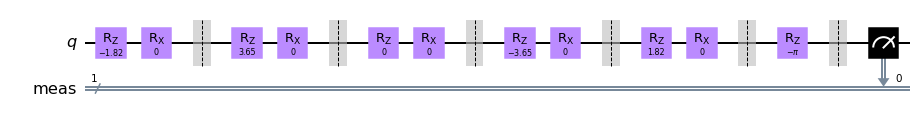

In [109]:
qsp_bb1(0).draw('mpl')

In [114]:
thetas = np.linspace(-np.pi, np.pi, 21)

In [115]:
qsp_circuits = []
rx_circuits = []

for theta in thetas:
    qsp_circuits.append( qsp_bb1(theta) )
    rx_circuits.append( Rx_circ(theta) )

In [116]:
qsp_p0s = []
for circuit in qsp_circuits:
    job = qasm_backend.run(circuit, shots=1000000)
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

In [117]:
rx_p0s = []
for circuit in rx_circuits:
    job = qasm_backend.run(circuit, shots=1000000)
    rx_p0s.append( calc_p0(job.result().get_counts()) )

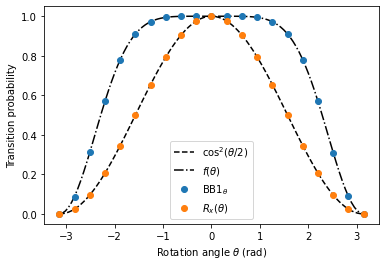

In [122]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

theory2 = (1/8) * np.cos(theta/2) ** 2 * (3 * np.cos(theta/2) ** 8 - 15 * np.cos(theta/2) ** 6 
                                         + 35 * np.cos(theta/2) ** 4 - 45 * np.cos(theta/2) ** 2 + 30)
plt.plot(theta, theory2, 'k-.', label=r'$f(\theta)$')

plt.plot(thetas, qsp_p0s, 'o', label=r'BB1$_\theta$')
plt.plot(thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

We see that results agree with the figure from [2] and the theoretical curve given by

\begin{equation}
    f(\theta) = \frac{1}{8} \cos^2\frac{\theta}{2} ( 3 \cos^8\frac{\theta}{2} - 15 \cos^6\frac{\theta}{2} + 35 \cos^4\frac{\theta}{2} - 45 \cos^2\frac{\theta}{2} + 30)
\end{equation}

which is also given in [2].

### IonQ simulator

We now seek to implement the QSP BB1 sequence and reproduce the figure using the IonQ simulator with the native gate set.
This is accomplished by a similar process.

In [136]:
def qsp_bb1_native(theta):
    
    circ = QuantumCircuit(1)
    
    eta = np.arccos(-1/4) / 2
    phi = [np.pi/2, -eta, 2*eta, 0, -2*eta, eta]

    # 5
    delay = -2*phi[5]/(2*np.pi)
    # R_x(theta)
    # The RZ phase shift is incorporated by the delay term
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 4
    # The new delay increases by the new phi and theta from previous gates
    delay += -2*phi[4]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 3
    delay += -2*phi[3]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 2
    delay += -2*phi[2]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    circ.barrier()
    
    # 1
    delay += -2*phi[1]/(2*np.pi) + theta
    # R_x(theta)
    circ.append(GPI2Gate(-0.25 + delay),[0]) 
    circ.append(GPI2Gate(0.25 + theta + delay),[0]) 
    
    # 0
    # circ.rz(phi=-2*phi[0], qubit=0)
    # We're supposed to have an Rz here but since it does not affect
    # the probabilities we just ignore it since we cannot implement it
    # using the IonQ system's current toolset.
    
    circ.measure_all()

    return circ

def Rx_circ_native(theta):
    circ = QuantumCircuit(1)

    # R_x(theta)
    circ.append(GPI2Gate(-0.25),[0]) 
    circ.append(GPI2Gate(0.25 + theta),[0]) 
    
    # Measure the qubit
    circ.measure_all()
    
    return circ

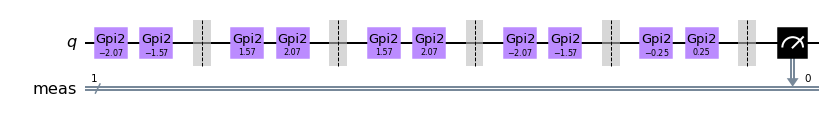

In [126]:
qsp_bb1_native(0).draw('mpl')

Generate the circuits:

In [12]:
# Need to modify to fractional rotations from radians for the native set
thetas = np.linspace(-0.5, 0.5, 11)

qsp_circuits = []
rx_circuits = []

for theta in thetas:
    qsp_circuits.append( qsp_bb1_native(theta) )
    rx_circuits.append( Rx_circ_native(theta) )

NameError: name 'qsp_bb1_native' is not defined

Run the circuits on the simulator:

In [138]:
qsp_p0s = []
for circuit in qsp_circuits:
    job = sim_backend_nat.run(circuit, shots=10000)
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

In [132]:
rx_p0s = []
for circuit in rx_circuits:
    job = sim_backend_nat.run(circuit, shots=10000)
    rx_p0s.append( calc_p0(job.result().get_counts()) )

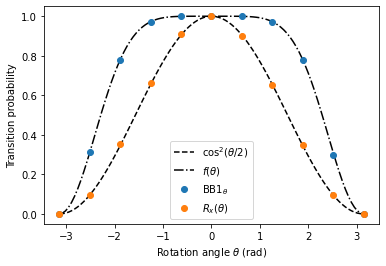

In [139]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

theory2 = (1/8) * np.cos(theta/2) ** 2 * (3 * np.cos(theta/2) ** 8 - 15 * np.cos(theta/2) ** 6 
                                         + 35 * np.cos(theta/2) ** 4 - 45 * np.cos(theta/2) ** 2 + 30)
plt.plot(theta, theory2, 'k-.', label=r'$f(\theta)$')


plt.plot(2*np.pi*thetas, qsp_p0s, 'o', label=r'BB1$_\theta$')
plt.plot(2*np.pi*thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

This reproduces the figure using the native gate set on the IonQ simulator.

### IonQ QPU

Now we run the same code on the IonQ QPU.

These jobs were submitted on Monday 6 June 2022 around 4 pm.

In [140]:
'''
qsp_jobs = []
print('Running jobs for the QSP circuits...')
for circuit in qsp_circuits:
    job = qpu_backend_nat.run(circuit, shots=10000)
    print('Job ID:', job.job_id())
'''

Running jobs for the QSP circuits...
Job ID: ceb541c2-872c-461e-a3e3-27a69775ff3b
Job ID: bae5fa52-c0b6-413e-bae3-1314e1d5b6b8
Job ID: fd307cbe-10e4-480d-95a0-d83e18999121
Job ID: 0ed139a2-d512-4039-bd58-9260a07211a3
Job ID: 03e3a593-64f1-4a79-b58c-f510a4bd5e38
Job ID: 93a94029-3549-436f-a5fa-1e7739b892aa
Job ID: 95aaf15f-10cd-42d9-86b9-f479b9bf7038
Job ID: 295de550-c47c-429b-b317-369331d2d828
Job ID: e9bd063f-d738-4e87-aeaf-83e2d2944e59
Job ID: e9a44f2a-e8bc-45fc-88f1-a84331e10e7c
Job ID: 2415f8e1-e527-4903-8cf4-b7f9e89cfa73


Copying the Job IDs below:

    Running jobs for the QSP circuits...
    Job ID: ceb541c2-872c-461e-a3e3-27a69775ff3b
    Job ID: bae5fa52-c0b6-413e-bae3-1314e1d5b6b8
    Job ID: fd307cbe-10e4-480d-95a0-d83e18999121
    Job ID: 0ed139a2-d512-4039-bd58-9260a07211a3
    Job ID: 03e3a593-64f1-4a79-b58c-f510a4bd5e38
    Job ID: 93a94029-3549-436f-a5fa-1e7739b892aa
    Job ID: 95aaf15f-10cd-42d9-86b9-f479b9bf7038
    Job ID: 295de550-c47c-429b-b317-369331d2d828
    Job ID: e9bd063f-d738-4e87-aeaf-83e2d2944e59
    Job ID: e9a44f2a-e8bc-45fc-88f1-a84331e10e7c
    Job ID: 2415f8e1-e527-4903-8cf4-b7f9e89cfa73

In [5]:
qsp_jobs_retrieved = [qpu_backend_nat.retrieve_job('ceb541c2-872c-461e-a3e3-27a69775ff3b'),
                      qpu_backend_nat.retrieve_job('bae5fa52-c0b6-413e-bae3-1314e1d5b6b8'),
                      qpu_backend_nat.retrieve_job('fd307cbe-10e4-480d-95a0-d83e18999121'),
                      qpu_backend_nat.retrieve_job('0ed139a2-d512-4039-bd58-9260a07211a3'),
                      qpu_backend_nat.retrieve_job('03e3a593-64f1-4a79-b58c-f510a4bd5e38'),
                      qpu_backend_nat.retrieve_job('93a94029-3549-436f-a5fa-1e7739b892aa'),
                      qpu_backend_nat.retrieve_job('95aaf15f-10cd-42d9-86b9-f479b9bf7038'),
                      qpu_backend_nat.retrieve_job('295de550-c47c-429b-b317-369331d2d828'),
                      qpu_backend_nat.retrieve_job('e9bd063f-d738-4e87-aeaf-83e2d2944e59'),
                      qpu_backend_nat.retrieve_job('e9a44f2a-e8bc-45fc-88f1-a84331e10e7c'),
                      qpu_backend_nat.retrieve_job('2415f8e1-e527-4903-8cf4-b7f9e89cfa73')
                     ] 

print('QSP Jobs are done?')
for job in qsp_jobs_retrieved:
    print(job.done())

QSP Jobs are done?
True
True
True
True
True
True
True
True
True
True
True


In [152]:
'''
rx_jobs = []
print('Running jobs for the Rx circuits...')
for circuit in rx_circuits:
    job = qpu_backend_nat.run(circuit, shots=10000)
    print('Job ID:', job.job_id())
'''

Running jobs for the Rx circuits...
Job ID: 415bd81a-43df-4b41-810f-2a2c503a7a84
Job ID: 8cf7a1ee-01d2-4619-9b59-46c98cd2e76d
Job ID: 6bc180b6-753e-4fd4-bd77-6396ea1a69ee
Job ID: 8b17d21a-b7b8-4723-8934-aa8cf08a51bc
Job ID: 999a3110-114e-4466-8c30-8ee482cd696c
Job ID: 704e018c-23c0-46ac-a146-5b6a68a28377
Job ID: 26c541d1-dc15-43c7-a772-a67f83726e45
Job ID: 23b33eb3-5e41-436c-ab0a-bc32b48e2e47
Job ID: 30cd4db4-40d2-482b-a0dc-eaf5983271bc
Job ID: 96adec6b-c466-4ea1-958d-2dac93fcca39
Job ID: 2d668b8c-8cde-4584-803c-2a3d7bba13b9


(I accidentally submitted multiple jobs so the IDs do not match here)

These are the actual job IDs (the others were cancelled):

    Running jobs for the Rx circuits...
    Job ID: d703767e-e784-459f-8b7b-dc18261c6591
    Job ID: 9a893c74-f4ce-4b64-b7ce-315b1ee42c98
    Job ID: 8403283d-0e97-49fe-8d87-dd421ddadc8f
    Job ID: ef523668-9586-45aa-8ed5-d21f38065f19
    Job ID: 5e6c6fc5-ce78-4c1f-9632-90e5ba2023c1
    Job ID: 11db1616-f182-4d12-bc35-96db0c85948a
    Job ID: d5f2440c-f240-4368-a60c-06fbe5d3284b
    Job ID: 12efef36-4d50-463c-89d8-f26666a84947
    Job ID: d2ffc60f-3367-4ffc-aad8-a0d71c9d6121
    Job ID: 3f65abc4-3e33-4957-80cf-c7820882ecf5
    Job ID: 341eac5e-6091-41d4-8449-6da963fc5e34

In [6]:
rx_jobs_retrieved = [qpu_backend_nat.retrieve_job('d703767e-e784-459f-8b7b-dc18261c6591'),
                     qpu_backend_nat.retrieve_job('9a893c74-f4ce-4b64-b7ce-315b1ee42c98'),
                     qpu_backend_nat.retrieve_job('8403283d-0e97-49fe-8d87-dd421ddadc8f'),
                     qpu_backend_nat.retrieve_job('ef523668-9586-45aa-8ed5-d21f38065f19'),
                     qpu_backend_nat.retrieve_job('5e6c6fc5-ce78-4c1f-9632-90e5ba2023c1'),
                     qpu_backend_nat.retrieve_job('11db1616-f182-4d12-bc35-96db0c85948a'),
                     qpu_backend_nat.retrieve_job('d5f2440c-f240-4368-a60c-06fbe5d3284b'),
                     qpu_backend_nat.retrieve_job('12efef36-4d50-463c-89d8-f26666a84947'),
                     qpu_backend_nat.retrieve_job('d2ffc60f-3367-4ffc-aad8-a0d71c9d6121'),
                     qpu_backend_nat.retrieve_job('3f65abc4-3e33-4957-80cf-c7820882ecf5'),
                     qpu_backend_nat.retrieve_job('341eac5e-6091-41d4-8449-6da963fc5e34')
                    ] 

print('Rx Jobs are done?')
for job in rx_jobs_retrieved:
    print(job.done())

Rx Jobs are done?
True
True
True
True
True
True
True
True
True
True
True


Processing the results:

In [9]:
qsp_p0s = []
for job in qsp_jobs_retrieved:
    print(job.result().get_counts())
    qsp_p0s.append( calc_p0(job.result().get_counts()) )

{'0': 151, '1': 9849}
{'0': 3034, '1': 6966}
{'0': 7810, '1': 2190}
{'0': 9691, '1': 309}
{'0': 9971, '1': 29}
{'0': 15988}
{'0': 9929, '1': 71}
{'0': 9216, '1': 784}
{'0': 7018, '1': 2982}
{'0': 2694, '1': 7306}
{'0': 86, '1': 9914}


In [10]:
rx_p0s = []
for job in rx_jobs_retrieved:
    print(job.result().get_counts())
    rx_p0s.append( calc_p0(job.result().get_counts()) )

{'0': 46, '1': 9954}
{'0': 976, '1': 9024}
{'0': 3437, '1': 6563}
{'0': 6506, '1': 3494}
{'0': 8994, '1': 1006}
{'0': 14992}
{'0': 9076, '1': 924}
{'0': 6656, '1': 3344}
{'0': 3538, '1': 6462}
{'0': 1075, '1': 8925}
{'0': 50, '1': 9950}


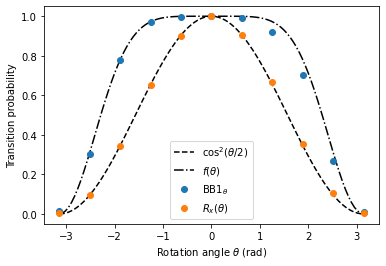

In [13]:
theta = np.linspace(-np.pi, np.pi, 100)
theory1 = np.cos(theta/2) ** 2 
plt.plot(theta, theory1, 'k--', label=r'$\cos^2(\theta/2)$')

theory2 = (1/8) * np.cos(theta/2) ** 2 * (3 * np.cos(theta/2) ** 8 - 15 * np.cos(theta/2) ** 6 
                                         + 35 * np.cos(theta/2) ** 4 - 45 * np.cos(theta/2) ** 2 + 30)
plt.plot(theta, theory2, 'k-.', label=r'$f(\theta)$')


plt.plot(2*np.pi*thetas, qsp_p0s, 'o', label=r'BB1$_\theta$')
plt.plot(2*np.pi*thetas, rx_p0s, 'o', label=r'$R_x(\theta)$')

plt.ylabel(r'Transition probability')
plt.xlabel(r'Rotation angle $\theta$ (rad)')

plt.legend()

plt.show()

## Conclusion and discussion

